## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
np.random.seed(53)

# new column to binarize party, where independents are grouped with democrats
congress_tweets['party_binary'] = np.where(congress_tweets['party']=="Republican", "Republican", "Democrat")

# sample 1000 tweets from Dem sens, Dem reps, Rep sens, Rep reps
congress_tweets = congress_tweets.groupby(['party_binary', 'position'], group_keys=False).apply(lambda x: x.sample(1000))
congress_tweets.reset_index(inplace = True, drop = True)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_binary
0,1.226990e+18,RepGwenMoore,2020-02-10T17:01:24-05:00,RT @NationalNOW Thank you to our sponsor @RepG...,Gwen Moore,Rep,3-Jan-05,4/18/1951,F,WI,4,Democrat,"1,405,284","1,382,536","1,620,985","1,407,966",Democrat
1,1.196850e+18,RepJuanVargas,2019-11-19T12:48:20-05:00,RT @TheBlackCaucus It is UNFATHOMABLE \nthat a...,Juan Vargas,Rep,3-Jan-13,3/7/1961,M,CA,51,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat
2,1.138260e+18,RepCohen,2019-06-10T21:49:17-04:00,"The #MuellerReport isn’t just a smoking gun, i...",Steve Cohen,Rep,3-Jan-07,5/24/1949,M,TN,9,Democrat,"1,522,925","870,695","960,709","1,462,330",Democrat
3,1.247960e+18,RepVeasey,2020-04-08T14:34:39-04:00,I applaud today’s announcement that will secur...,Marc Veasey,Rep,3-Jan-13,1/3/1971,M,TX,33,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Democrat
4,1.103420e+18,RepRoybalAllard,2019-03-06T17:36:50-05:00,RT @EndChildPovCA Yes! Thank you @RepBarbaraLe...,Lucille Roybal-Allard,Rep,3-Jan-93,6/12/1941,F,CA,40,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
import re

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # adding symbols specific to tweets
    nlp.Defaults.stop_words |= {"RT", '\n', '\n\n' '“', '”', '—', '–', 'QT'}
    punc = set(punctuation)
    punc.remove('&') # '&' on Twitter is scraped as '&amp'
    
    fix_text = re.sub(r"&amp", "and", text) #replace all '&and' with 'and'
    
    punc_free = "".join([ch for ch in fix_text if ch not in punc])
    
    doc = nlp(punc_free)
    
    # lemmatization instead of tokenization
    spacy_words = [token.lemma_ for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

**KQ**: nice job on the preprocessing, removing the boilerplate twitter text and linebreaks would just be picking up noise

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

In [4]:
congress_tweets['tokens_list'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens'] = congress_tweets['tokens_list'].map(lambda text: ' '.join(text))
congress_tweets['tokens']

0       NationalNOW thank sponsor RepGwenMoore incredi...
1       theblackcaucus UNFATHOMABLE Americans prepare ...
2       MuellerReport smoking gun ’ smoking cannon unf...
3       I applaud today announcement secure critical f...
4       endchildpovca yes thank repbarbaralee SpeakerP...
                              ...                        
3995    grow number Dems Buck Pelosi Federal Worker Pa...
3996    MarshaBlackburn Adam Schiff lie partisan agend...
3997    I introduce EBRIDGE Act remove red tape come w...
3998    today smallbusinesssaturday I encourage Alabam...
3999    WVDHHR Free covid19 testing weekend Marshall M...
Name: tokens, Length: 4000, dtype: object

### EDA 1: n-grams

In [5]:
# Initialize the BOW countervectorizer
countvec = CountVectorizer(stop_words = STOP_WORDS, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

C:\Users\atarv\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'qt', 'rt', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,ngrams,freq
0,health care,117
1,president trump,101
2,small business,97
3,american people,68
4,united states,60


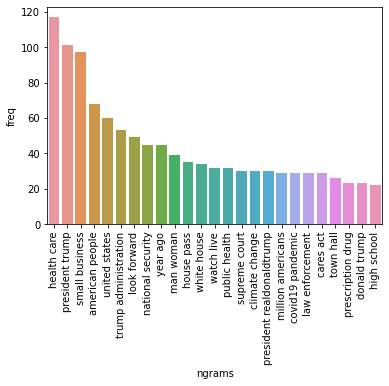

In [6]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**KQ**: nice job on these. This is really clear and interpretable !

Do members of both parties use similar words?

In [7]:
dem = congress_tweets[congress_tweets["party_binary"]=="Democrat"].copy()
repub = congress_tweets[congress_tweets["party_binary"]=="Republican"].copy()

ngrams_dem = countvec.fit_transform(dem['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams_dem.todense(), columns = countvec.get_feature_names())

df_ngram_dem = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram_dem = df_ngram_dem.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram_dem.head()

,ngrams,freq
0,health care,77
1,president trump,67
2,trump administration,43
3,small business,42
4,american people,37


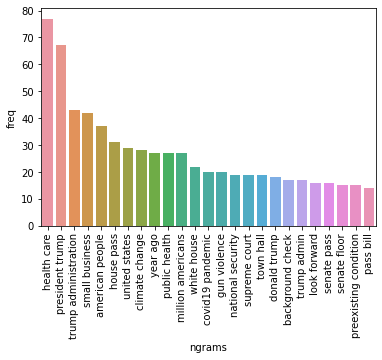

In [8]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram_dem[0:25])
plt.xticks(rotation=90)
plt.show()

In [9]:
ngrams_rep = countvec.fit_transform(repub['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams_rep.todense(), columns = countvec.get_feature_names())

df_ngram_rep = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram_rep = df_ngram_rep.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram_rep.head()

,ngrams,freq
0,small business,55
1,health care,40
2,president trump,34
3,look forward,33
4,united states,31


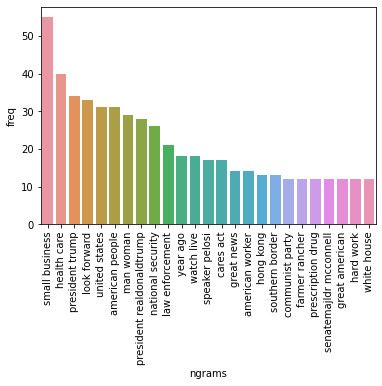

In [10]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram_rep[0:25])
plt.xticks(rotation=90)
plt.show()

Democrats and Republicans seems to use different kinds of words in their tweets. For example, Democrats are more likely to talk about Trump, whereas Republicans are more likely to tweet at Trump. Additionally, it seems that Democrats talk more about topics such as climate change and the health impact of COVID19, whereas Republicans focus more on the small business owner and the threat of communism.

Now to repeat for Senators and Representatives:

In [11]:
rep = congress_tweets[congress_tweets["position"]=="Rep"].copy()
sen = congress_tweets[congress_tweets["position"]=="Sen"].copy()

ngrams_repr = countvec.fit_transform(rep['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams_repr.todense(), columns = countvec.get_feature_names())

df_ngram_repr = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram_repr = df_ngram_repr.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram_repr.head()

,ngrams,freq
0,small business,59
1,president trump,47
2,health care,45
3,american people,41
4,united states,26


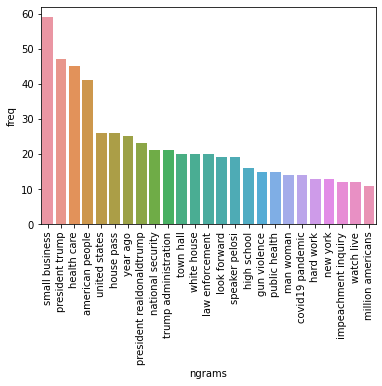

In [12]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram_repr[0:25])
plt.xticks(rotation=90)
plt.show()

**KQ**: these plots look good. Don't forget to add titles and some interpretations (i.e., does there appear to be a systematic difference between the bigrams for the different classes)! 

In [13]:
ngrams_sen = countvec.fit_transform(sen['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams_sen.todense(), columns = countvec.get_feature_names())

df_ngram_sen = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram_sen = df_ngram_sen.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram_sen.head()

,ngrams,freq
0,health care,72
1,president trump,54
2,small business,38
3,united states,34
4,trump administration,32


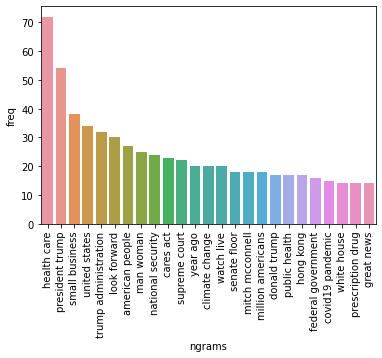

In [14]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram_sen[0:25])
plt.xticks(rotation=90)
plt.show()

Senators and Representatives, however, do not appear to differ as much as Democrats and Republicans in the use of n-grams.

### EDA 2: Topic modelling

Below, the number of topics is set to 15, but I also performed topic modelling with 10 and 20 topics, but found 15 to be more interpretable and more clearly delineated.

In [15]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

lda = LatentDirichletAllocation(n_components=15, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
king cut art progress minnesota justice luther martin clean schiff memorialday  
 little place innovation enhance adam cares regulation competition

Topic #1:
late icymi nra york technology incentivize happy justice contain involve preexist innovation contractor fairness condition firsthand fbi art iii interest

Topic #2:
I 

  today   work need    trump help president act people bill covid19 health ' time american support thank

Topic #3:
enforcement officer essential mental caresact shoot suicide justice unveil succeed vulnerable pleased ☀ reopen peace hoosi place weapon command condition

Topic #4:
testing test quality affordable task medicare whitehouse condition place strengthen regardless 🚨 january ahead infrastructure iran treasury ohio preexist internship

Topic #5:
vaccine test spread politic vulnerable interest mitch distribution reject deadly southern firefighter suffer place hate muchneede infrastructure doctrine essential cut

Topic #6:
de el la ❌ y los deadline

The topic modelling with 15 topics is fairly interpretable, with the following topic possibilities:

* 0- Racial justice
* 2- COVID19 social issues
* 3- Policing
* 4- Heath care
* 5- COVID19 testing
* 6- Spanish language
* 11- Selection of Amy Coney Barrett as SCJ
* 12- COVID19 spread
* 14- Natural disasters

### EDA 3: Tweet length

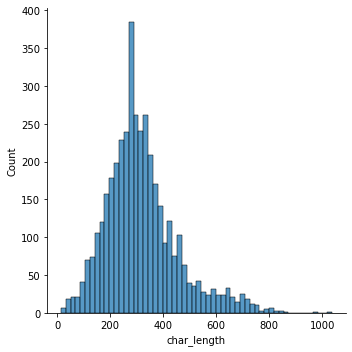

In [16]:
# length of characters
congress_tweets['char_length'] = congress_tweets['text'].apply(len)

# number of words
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

sns.displot(congress_tweets, x="char_length")
plt.show()

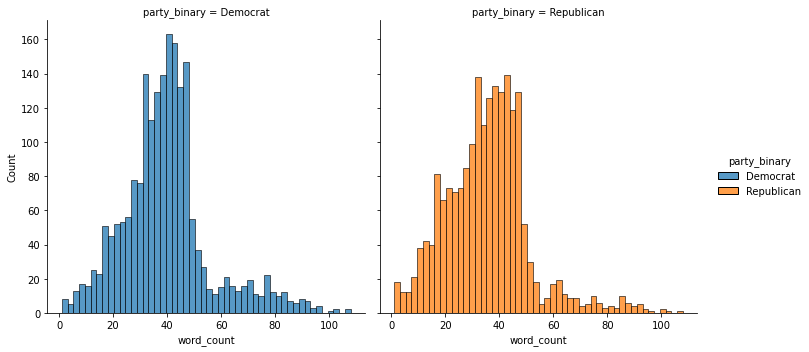

In [17]:
sns.displot(congress_tweets, x="word_count", hue = "party_binary", col = "party_binary")
plt.show()

Republicans have a slight skew towards shorter tweets.

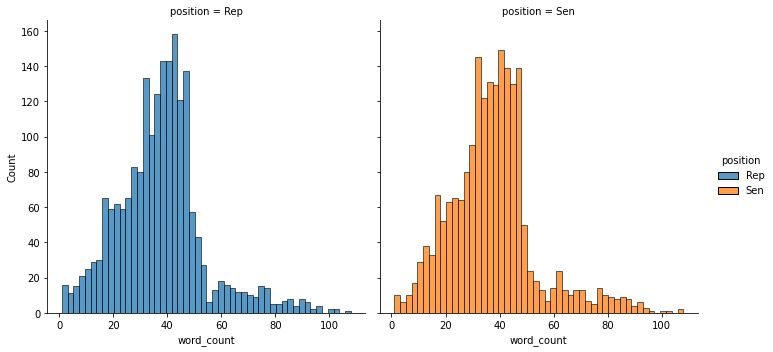

In [18]:
sns.displot(congress_tweets, x="word_count", hue = "position", col = "position")
plt.show()

The distribution of word length is fairly similar between Representatives and Senators.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [19]:
# Conservative: Ted Yoho
# Liberal: Barbara Lee

# get full data from each person
full_df = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
ted = full_df[full_df["name_wikipedia"]=="Ted Yoho"].copy()
barbara = full_df[full_df["name_wikipedia"]=="Barbara Lee"].copy()
sample = ted.append(barbara)
print(ted.shape, barbara.shape, sample.shape)

(966, 16) (3529, 16) (4495, 16)


In [20]:
# remove stop words and punctuation, lemmatize
sample['tokens'] = sample['text'].apply(lambda x: rem_punc_stop(x))
sample['tokens'] = sample['tokens'].map(lambda text: ' '.join(text))
sample['tokens']

196599    Xi Jinping threaten rhetoric Taiwan escalation...
196684    join HARRISFAULKNER 130pm today discuss US tro...
196909    today lawenforcementappreciationday Law enforc...
197386    today I introduce proveteran bill wingman supp...
197609    today thousand Americans gather March Life ral...
                                ...                        
157737    update Coin Redesign Act bill help recognize r...
157738                   stimulus check \n\n survival check
157793    new year I hopeful tackle covid19 systemic rac...
157838    instead fund endless war fund end hunger suffe...
157839    12 year Oscar Grant murder platform Fruitvale ...
Name: tokens, Length: 4495, dtype: object

In [21]:
# Calculate polarity for each tweet for both people
sample['polarity'] = sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
sample.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity
196599,1.081310e+18,RepTedYoho,2019-01-04T17:00:52-05:00,Xi Jinping’s threatening rhetoric on #Taiwan i...,Ted Yoho,Rep,3-Jan-13,4/13/1955,M,FL,3,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",Xi Jinping threaten rhetoric Taiwan escalation...,0.000000
196684,1.082340e+18,RepTedYoho,2019-01-07T13:14:50-05:00,Will be joining @HARRISFAULKNER at 1:30pm toda...,Ted Yoho,Rep,3-Jan-13,4/13/1955,M,FL,3,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",join HARRISFAULKNER 130pm today discuss US tro...,0.500000
196909,1.083070e+18,RepTedYoho,2019-01-09T13:46:39-05:00,Today is #LawEnforcementAppreciationDay. Law e...,Ted Yoho,Rep,3-Jan-13,4/13/1955,M,FL,3,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",today lawenforcementappreciationday Law enforc...,0.066667
197386,1.085680e+18,RepTedYoho,2019-01-16T18:36:18-05:00,"Today I introduced a pro-veteran bill, WINGMAN...",Ted Yoho,Rep,3-Jan-13,4/13/1955,M,FL,3,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",today I introduce proveteran bill wingman supp...,0.000000
197609,1.086390e+18,RepTedYoho,2019-01-18T17:17:50-05:00,Today thousands of Americans gathered for the ...,Ted Yoho,Rep,3-Jan-13,4/13/1955,M,FL,3,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",today thousand Americans gather March Life ral...,0.000000


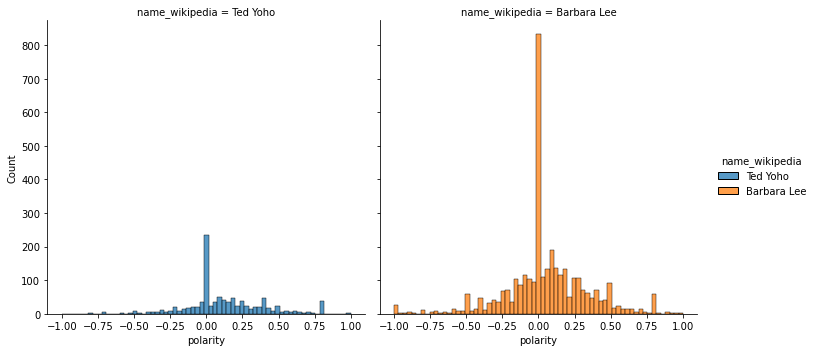

In [22]:
sns.displot(sample, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

It appears that there is a slight positive skew for Ted Yoho, where there is a bit more of an even distribution for Barbara Lee. I think this could be an expected outcome as it appears that a dominant strategy of Republicans is inciting Americana pride and positivity for the future, whereas Democrats tend to talk more about issues negatively impacting the country.

**KQ**: this makes me wonder how things would change if a democrat were president, as the opposing party might be more critical on twitter

### Democrats vs Republicans

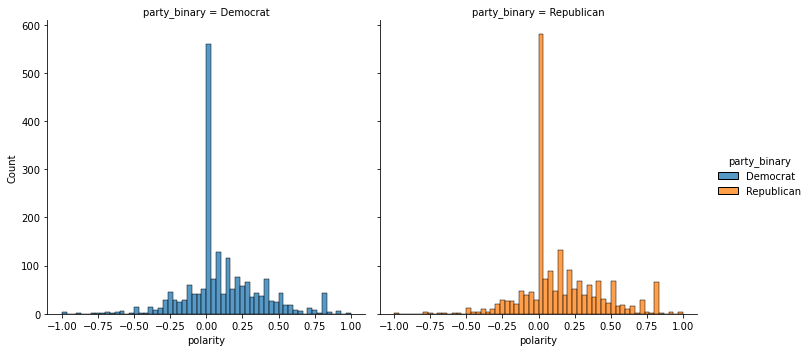

In [23]:
# now calculate polarity of each tweet in our sample of 4,000 tweets
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x="polarity", hue = "party_binary", col = "party_binary")
plt.show()

### Senators vs Representatives

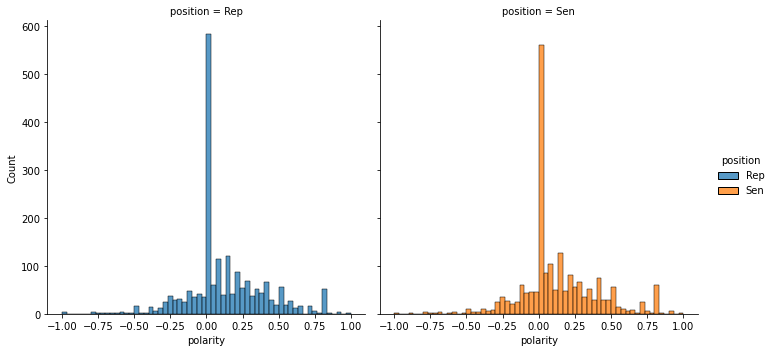

In [24]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

Polarity does not seem to be a distinguishing characteristic of Democrats' vs Republicans' tweets, or of Senators' vs Representatives' tweets.

Below, the method will be repeated with subjectivity scores.

**KQ**: why might this be? 

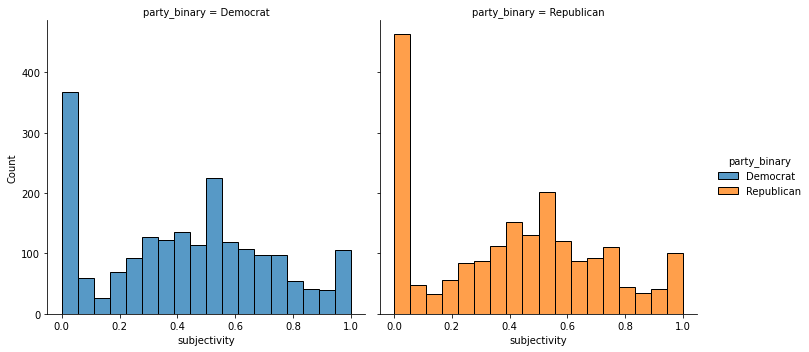

In [25]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity", hue = "party_binary", col = "party_binary")
plt.show()

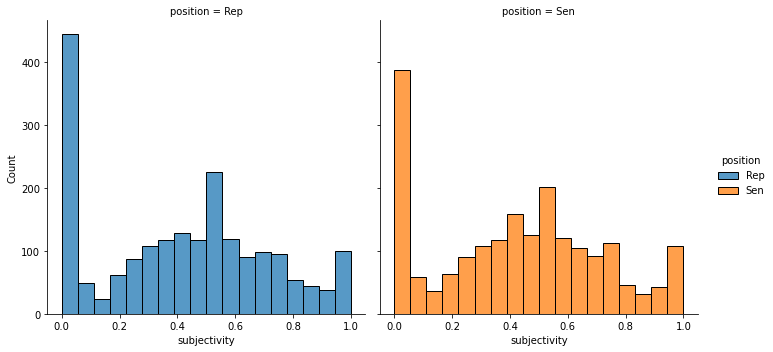

In [26]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

Once again, measures of sentiment do not seem particularly distinguishing for either Democrats vs Republicans or Representatives vs Senators.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [27]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'party_binary', 'tokens_list', 'tokens',
       'char_length', 'word_count', 'polarity', 'subjectivity'],
      dtype='object')

### Engineered Text Features

In [28]:
# Engineered Features
engineered = congress_tweets[['char_length', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)
engineered.head()

,char_length,word_count,polarity,subjectivity
0,170,15,0.900000,0.900000
1,381,37,0.400000,0.800000
2,461,43,0.000000,0.541667
3,412,38,0.233333,0.500000
4,431,35,0.000000,0.000000


In [29]:
# add in topics
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist)
engineered_with_topics = topic_dist_df.join(engineered)
engineered_with_topics.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,char_length,word_count,polarity,subjectivity
0,0.017827,0.017827,0.211504,0.017827,0.017827,0.017827,0.017827,0.017827,0.556742,0.017827,0.017827,0.017827,0.017827,0.017827,0.017827,170,15,0.900000,0.900000
1,0.011987,0.011987,0.635578,0.011987,0.011987,0.011987,0.011987,0.011987,0.208592,0.011987,0.011987,0.011987,0.011987,0.011987,0.011987,381,37,0.400000,0.800000
2,0.012728,0.012728,0.371611,0.012728,0.012728,0.012728,0.012728,0.012728,0.012728,0.012728,0.012728,0.012728,0.012728,0.462927,0.012728,461,43,0.000000,0.541667
3,0.012511,0.012511,0.578220,0.259131,0.012512,0.012511,0.012511,0.012512,0.012511,0.012511,0.012511,0.012511,0.012512,0.012511,0.012512,412,38,0.233333,0.500000
4,0.015136,0.015136,0.249525,0.553701,0.015136,0.015137,0.015136,0.015137,0.015137,0.015137,0.015137,0.015136,0.015136,0.015136,0.015136,431,35,0.000000,0.000000


### Bag-of-words or Tf-idf

In [30]:
# Frequency Based featurization
tfidf_df = pd.DataFrame(dense_matrix)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13692,13693,13694,13695,13696,13697,13698,13699,13700,13701
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.148774,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.089463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [31]:
model = gensim.models.Word2Vec(congress_tweets['tokens_list'], vector_size=100, window=3, 
                               min_count=5, sg=0, alpha=0.025, epochs=5, batch_words=10000)
words = list(model.wv.index_to_key)
print("Number of vectors:", len(words))

Number of vectors: 2727


In [32]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [33]:
empty_list_embeddings_means = []
for tweet in congress_tweets['tokens_list']: # append the vector for each document
    doc = [word for word in tweet if word in model.wv.index_to_key]
    
    # skip over tweets with no vectors (maybe just emojis?)
    if len(doc) != 0:
        empty_list_embeddings_means.append(document_vector(model, tweet))
    # tag empty tweets with nan to be fixed later
    else:
        empty_list_embeddings_means.append(np.empty((100,)))
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

doc_average_embeddings.shape

(4000, 100)

In [34]:
# embedding based featurization
# NOTE: tweets with no vectors are represented with nan, to be dropped later but order preserved
doc_avg_emb_df = pd.DataFrame(doc_average_embeddings)
print(doc_avg_emb_df.shape)
doc_avg_emb_df.head()

(4000, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.201864,0.212335,0.034427,0.055971,0.007781,-0.424803,0.092682,0.528746,-0.119848,-0.178623,...,0.407705,0.185867,0.025228,0.139872,0.478561,0.301166,0.136828,-0.298438,0.053767,0.012892
1,-0.200199,0.206200,0.029944,0.052720,0.002217,-0.414836,0.091039,0.521040,-0.115118,-0.175861,...,0.400436,0.193567,0.023252,0.135813,0.478182,0.301609,0.135101,-0.300762,0.055999,0.007112
2,-0.156357,0.154672,0.023684,0.042993,0.002979,-0.320341,0.068405,0.404825,-0.091422,-0.135894,...,0.310197,0.146471,0.020643,0.105806,0.369334,0.230374,0.104806,-0.231441,0.046234,0.008425
3,-0.247376,0.257352,0.038041,0.067018,0.002985,-0.516300,0.113788,0.650381,-0.150051,-0.223026,...,0.502062,0.238452,0.025027,0.169030,0.596222,0.371365,0.168625,-0.376850,0.072042,0.012612
4,-0.229738,0.236331,0.032267,0.062683,0.006035,-0.474956,0.105162,0.591215,-0.131468,-0.198776,...,0.455174,0.213190,0.027440,0.156992,0.541168,0.334144,0.154481,-0.337722,0.063093,0.014793


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [35]:
# convert strings to floats
congress_tweets['clinton_2016_state_share'] = congress_tweets['clinton_2016_state_share'].map(lambda x: float(x.replace(',', '')))
congress_tweets['trump_2016_state_share'] = congress_tweets['trump_2016_state_share'].map(lambda x: float(x.replace(',', '')))
congress_tweets['obama_2012_state_share'] = congress_tweets['obama_2012_state_share'].map(lambda x: float(x.replace(',', '')))
congress_tweets['romney_2012_state_share'] = congress_tweets['romney_2012_state_share'].map(lambda x: float(x.replace(',', '')))

In [36]:
# calculate state's share Dem and Repub for 2016 and 2012
congress_tweets['dem_votes_2016'] = congress_tweets.apply(lambda x: x['clinton_2016_state_share']/(x['clinton_2016_state_share'] + x['trump_2016_state_share']), axis = 1)
congress_tweets['rep_votes_2016'] = congress_tweets.apply(lambda x: x['trump_2016_state_share']/(x['clinton_2016_state_share'] + x['trump_2016_state_share']), axis = 1)
congress_tweets['dem_votes_2012'] = congress_tweets.apply(lambda x: x['obama_2012_state_share']/(x['obama_2012_state_share'] + x['romney_2012_state_share']), axis = 1)
congress_tweets['rep_votes_2012'] = congress_tweets.apply(lambda x: x['romney_2012_state_share']/(x['obama_2012_state_share'] + x['romney_2012_state_share']), axis = 1)              

In [37]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'party_binary', 'tokens_list', 'tokens',
       'char_length', 'word_count', 'polarity', 'subjectivity',
       'dem_votes_2016', 'rep_votes_2016', 'dem_votes_2012', 'rep_votes_2012'],
      dtype='object')

In [38]:
from sklearn.preprocessing import LabelBinarizer

# Target
lb_style = LabelBinarizer()
y_party = congress_tweets['party_binary_01'] = lb_style.fit_transform(congress_tweets["party_binary"])
y_pos = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

# Features
nontext = congress_tweets.drop(['party_binary_01', 'party_binary', 'party',
                         'position_binary', 'position', 'tokens_list', 'tokens',
       'char_length', 'word_count', 'polarity', 'subjectivity', 'text',
                               'trump_2016_state_share', 'clinton_2016_state_share',
                               'obama_2012_state_share', 'romney_2012_state_share', 'tweet_id', 'datetime', 'screen_name'], axis = 1)

### Engineered features - party predictions

In [39]:
from sklearn.model_selection import train_test_split
# for party lines
X_train_efpart, X_test_efpart, y_train_efpart, y_test_efpart = train_test_split(engineered_with_topics, y_party, train_size = .80, test_size=0.20,
                                                   stratify=y_party)

X_train_efpart, X_validate_efpart, y_train_efpart, y_validate_efpart = train_test_split(X_train_efpart, y_train_efpart, train_size = .75, test_size = .25, 
                                                           stratify = y_train_efpart)

In [40]:
from sklearn.linear_model import LogisticRegression
# create a model
logit_reg = LogisticRegression(max_iter = 1000)

# fit the model
logit_model = logit_reg.fit(X_train_efpart, y_train_efpart.ravel())

In [41]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_efpart, y_train_efpart)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_efpart)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_efpart))

{'C': 0.1, 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'liblinear'}
Validation Accuracy 0.555


In [42]:
logit_model = logit_grid.best_estimator_.fit(X_train_efpart, y_train_efpart.ravel())
y_pred = logit_model.predict(X_validate_efpart)

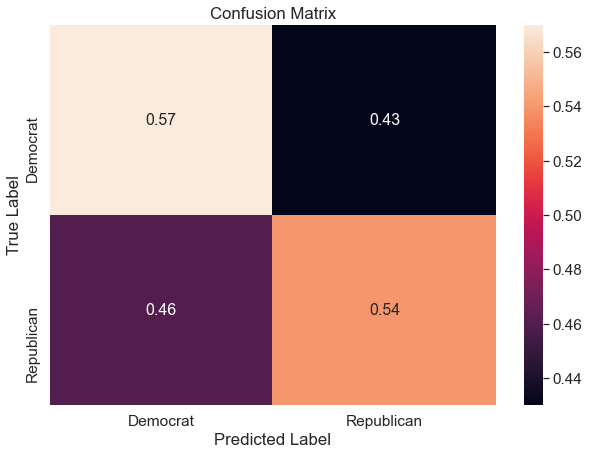

In [43]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_validate_efpart, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Engineered features - position predictions

In [44]:
# for position
X_train_efpos, X_test_efpos, y_train_efpos, y_test_efpos = train_test_split(engineered_with_topics, y_pos, train_size = .80, test_size=0.20,
                                                   stratify=y_pos)

X_train_efpos, X_validate_efpos, y_train_efpos, y_validate_efpos = train_test_split(X_train_efpos, y_train_efpos, train_size = .75, test_size = .25, 
                                                           stratify = y_train_efpos)

In [45]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_efpos, y_train_efpos.ravel())

In [46]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_efpos, y_train_efpos)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_efpos)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_efpos))

{'C': 0.1, 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'liblinear'}
Validation Accuracy 0.5025


In [47]:
logit_grid.best_estimator_.fit(X_train_efpos, y_train_efpos.ravel())
y_pred = logit_model.predict(X_validate_efpos)

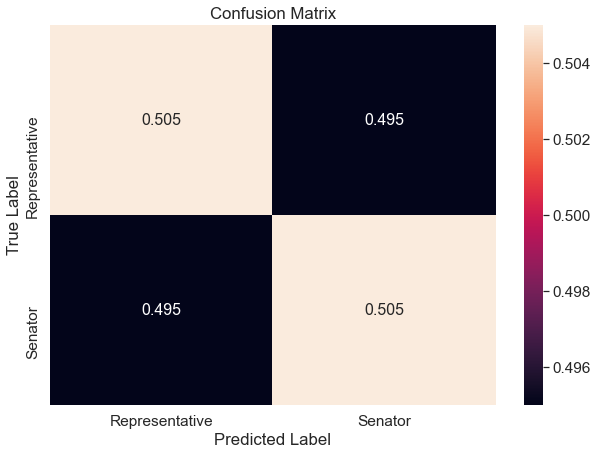

In [48]:
cf_matrix = confusion_matrix(y_validate_efpos, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

For engineered features, it is easier to predict party than position. Perhaps this indicates that within this featurization method, there is more polarization across party lines, whereas senators and representatives are not as different from one another. This seems to make sense as word count seemed to distinguish across party lines, where Democrats' tweets were generally longer, but neither word count nor sentiment scores seemed to do well at distinguishing between Representatives and Senators.

**KQ**: nice writeup here 

### tf-idf - party predictions

In [49]:
# for party
X_train_tfpart, X_test_tfpart, y_train_tfpart, y_test_tfpart = train_test_split(tfidf_df, y_party, train_size = .80, test_size=0.20,
                                                   stratify=y_party)

X_train_tfpart, X_validate_tfpart, y_train_tfpart, y_validate_tfpart = train_test_split(X_train_tfpart, y_train_tfpart, train_size = .75, test_size = .25, 
                                                           stratify = y_train_tfpart)

In [50]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_tfpart, y_train_tfpart.ravel())

In [51]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_tfpart, y_train_tfpart)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_tfpart)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_tfpart))

{'C': 0.9, 'fit_intercept': 'True', 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.715


In [52]:
logit_grid.best_estimator_.fit(X_train_tfpart, y_train_tfpart.ravel())
y_pred = logit_model.predict(X_validate_tfpart)

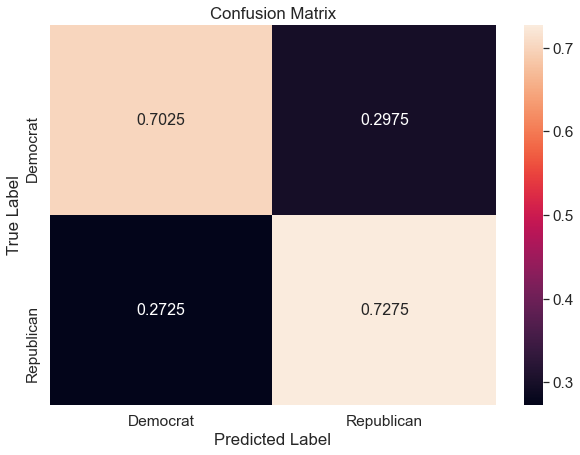

In [53]:
cf_matrix = confusion_matrix(y_validate_tfpart, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**KQ**: don't forget to add titles to the confusion matrices! You can tell which classes based on the axes but it's a bit more difficult to tell which feature sets you're using. Really nice job overall

### tf-idf - position predictions

In [54]:
# for position
X_train_tfpos, X_test_tfpos, y_train_tfpos, y_test_tfpos = train_test_split(tfidf_df, y_pos, train_size = .80, test_size=0.20,
                                                   stratify=y_pos)

X_train_tfpos, X_validate_tfpos, y_train_tfpos, y_validate_tfpos = train_test_split(X_train_tfpos, y_train_tfpos, train_size = .75, test_size = .25, 
                                                           stratify = y_train_tfpos)

In [55]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_tfpos, y_train_tfpos.ravel())

In [56]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_tfpos, y_train_tfpos)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_tfpos)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_tfpos))

{'C': 0.2, 'fit_intercept': 'True', 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.62875


In [57]:
logit_grid.best_estimator_.fit(X_train_tfpos, y_train_tfpos.ravel())
y_pred = logit_model.predict(X_validate_tfpos)

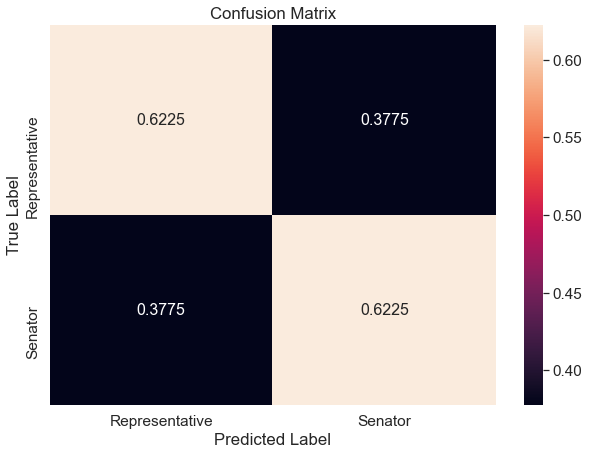

In [58]:
cf_matrix = confusion_matrix(y_validate_tfpos, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Token frequency inverse document frequency matrices provide the most distinguishing information for both party and position. However, the predictive accuracy for Democrats vs Republicans is still higher than that of Senators vs Representatives. Though this may provide evidence that Senators are more moderate than Representatives (and thus show differences in the words they use), they are not as easily separated as legislators on either side of party lines. Given the exploratory data analysis above, it is logical that tf-idf featurization gives such high predictive accuracy. In the visualizations of n-grams above, there were clear differences in word choice between Democrats and Republicans, and to a lesser extent, between Representatives and Senators.

**KQ**: excellent job here. Your models are doing quite well and you provide a thoughtful analysis of why these differences might emerge based on EDA

### Word embeddings - party predictions

In [59]:
# account for nan rows
emb_y = doc_avg_emb_df.copy()
emb_y['y_pos'] = y_pos
emb_y['y_party'] = y_party
emb_y.shape

(4000, 102)

In [60]:
# drop rows from both x and y that have nan in x
emb_y.dropna(axis = 0, inplace = True)
emb_y.reset_index(inplace = True, drop = True)
print(emb_y.shape)
emb_y.head()

(3990, 102)


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,y_pos,y_party
0,-0.201864,0.212335,0.034427,0.055971,0.007781,-0.424803,0.092682,0.528746,-0.119848,-0.178623,...,0.025228,0.139872,0.478561,0.301166,0.136828,-0.298438,0.053767,0.012892,0,0
1,-0.200199,0.206200,0.029944,0.052720,0.002217,-0.414836,0.091039,0.521040,-0.115118,-0.175861,...,0.023252,0.135813,0.478182,0.301609,0.135101,-0.300762,0.055999,0.007112,0,0
2,-0.156357,0.154672,0.023684,0.042993,0.002979,-0.320341,0.068405,0.404825,-0.091422,-0.135894,...,0.020643,0.105806,0.369334,0.230374,0.104806,-0.231441,0.046234,0.008425,0,0
3,-0.247376,0.257352,0.038041,0.067018,0.002985,-0.516300,0.113788,0.650381,-0.150051,-0.223026,...,0.025027,0.169030,0.596222,0.371365,0.168625,-0.376850,0.072042,0.012612,0,0
4,-0.229738,0.236331,0.032267,0.062683,0.006035,-0.474956,0.105162,0.591215,-0.131468,-0.198776,...,0.027440,0.156992,0.541168,0.334144,0.154481,-0.337722,0.063093,0.014793,0,0


In [61]:
# Targets
y_partyemb = emb_y['y_party']
y_posemb = emb_y['y_pos']

# Features
doc_avg_emb_df_nonan = emb_y.drop(['y_party', 'y_pos'], axis = 1)

In [62]:
# for party
X_train_embpart, X_test_embpart, y_train_embpart, y_test_embpart = train_test_split(doc_avg_emb_df_nonan, y_partyemb, train_size = .80, test_size=0.20,
                                                   stratify=y_partyemb)

X_train_embpart, X_validate_embpart, y_train_embpart, y_validate_embpart = train_test_split(X_train_embpart, y_train_embpart, train_size = .75, test_size = .25, 
                                                           stratify = y_train_embpart)

In [63]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_embpart, y_train_embpart.ravel())

In [64]:
# removed some hyperparameter options to reduce runtime
param_grid = {'penalty': ['l1', 'l2'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_embpart, y_train_embpart)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_embpart)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_embpart))

{'C': 0.6, 'fit_intercept': 'True', 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.543859649122807


In [65]:
logit_grid.best_estimator_.fit(X_train_embpart, y_train_embpart.ravel())
y_pred = logit_model.predict(X_validate_embpart)

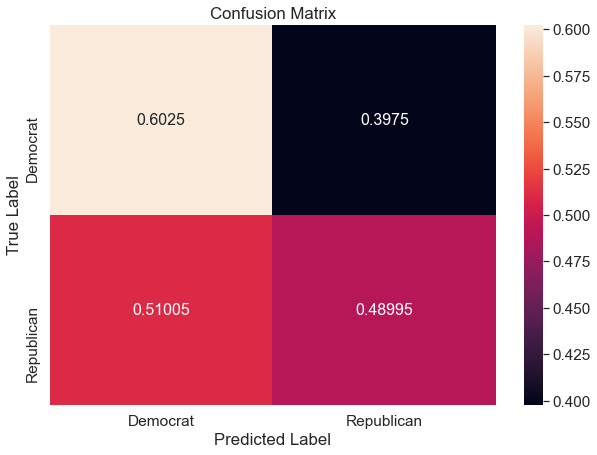

In [66]:
cf_matrix = confusion_matrix(y_validate_embpart, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Word embeddings - position predictions

In [67]:
# for party
X_train_embpos, X_test_embpos, y_train_embpos, y_test_embpos = train_test_split(doc_avg_emb_df_nonan, y_posemb, train_size = .80, test_size=0.20,
                                                   stratify=y_posemb)

X_train_embpos, X_validate_embpos, y_train_embpos, y_validate_embpos = train_test_split(X_train_embpos, y_train_embpos, train_size = .75, test_size = .25, 
                                                           stratify = y_train_embpos)

In [68]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_embpos, y_train_embpos.ravel())

In [69]:
# removed some hyperparameter options to reduce runtime
param_grid = {'penalty': ['l1', 'l2'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_embpos, y_train_embpos)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_embpos)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_embpos))

{'C': 0.8, 'fit_intercept': 'True', 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.5213032581453634


In [70]:
logit_grid.best_estimator_.fit(X_train_embpos, y_train_embpos.ravel())
y_pred = logit_model.predict(X_validate_embpos)

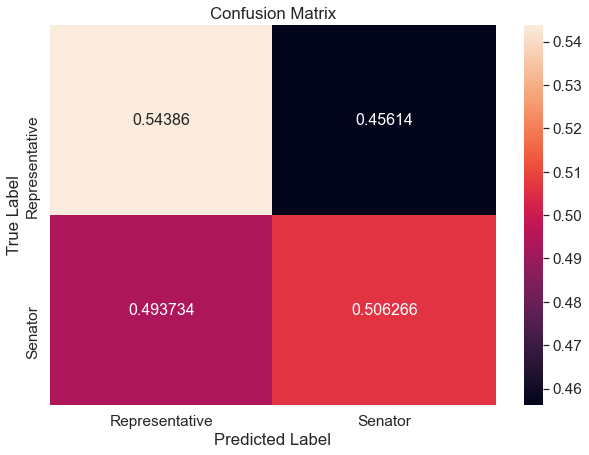

In [71]:
cf_matrix = confusion_matrix(y_validate_embpos, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

It is possible that word embeddings remove too much distinguishing information as the embeddings are made up of vectors of length 100. It is still more difficult to predict position than party, and Democrats and Representatives are easier to predict (higher true positives) than Republicans and Senators. Based on the data above, the best featurization technique is term frequency inverse document frequency.

### Two Combined Models with tf-idf

In [72]:
nontext.columns

Index(['name_wikipedia', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'dem_votes_2016', 'rep_votes_2016', 'dem_votes_2012',
       'rep_votes_2012'],
      dtype='object')

In [73]:
nontext.drop(['joined_congress_date', 'district_number', 'joined_congress_date', 'birthday'], axis = 1, inplace = True)
nontext.columns

Index(['name_wikipedia', 'gender', 'state', 'dem_votes_2016', 'rep_votes_2016',
       'dem_votes_2012', 'rep_votes_2012'],
      dtype='object')

In [74]:
nontext_dummies = pd.get_dummies(nontext)
nontext_dummies.head()

,dem_votes_2016,rep_votes_2016,dem_votes_2012,rep_votes_2012,name_wikipedia_Abby Finkenauer,name_wikipedia_Abigail Spanberger,name_wikipedia_Adam Schiff,name_wikipedia_Adam Smith,name_wikipedia_Adrian Smith,name_wikipedia_Adriano Espaillat,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.495920,0.504080,0.535164,0.464836,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.661282,0.338718,0.618728,0.381272,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.363757,0.636243,0.396489,0.603511,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.452868,0.547132,0.419921,0.580079,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.661282,0.338718,0.618728,0.381272,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
combined_x = nontext_dummies.join(tfidf_df)
combined_x.head()

,dem_votes_2016,rep_votes_2016,dem_votes_2012,rep_votes_2012,name_wikipedia_Abby Finkenauer,name_wikipedia_Abigail Spanberger,name_wikipedia_Adam Schiff,name_wikipedia_Adam Smith,name_wikipedia_Adrian Smith,name_wikipedia_Adriano Espaillat,...,13692,13693,13694,13695,13696,13697,13698,13699,13700,13701
0,0.495920,0.504080,0.535164,0.464836,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.661282,0.338718,0.618728,0.381272,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.363757,0.636243,0.396489,0.603511,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.452868,0.547132,0.419921,0.580079,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.661282,0.338718,0.618728,0.381272,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Party predictions

In [76]:
# for party
X_train_ntpart, X_test_ntpart, y_train_ntpart, y_test_ntpart = train_test_split(combined_x, y_party, train_size = .80, test_size=0.20,
                                                   stratify=y_party)

X_train_ntpart, X_validate_ntpart, y_train_ntpart, y_validate_ntpart = train_test_split(X_train_ntpart, y_train_ntpart, train_size = .75, test_size = .25, 
                                                           stratify = y_train_ntpart)

In [77]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_ntpart, y_train_ntpart.ravel())

In [78]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_ntpart, y_train_ntpart)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_ntpart)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_ntpart))

{'C': 0.9, 'fit_intercept': 'True', 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.95625


In [79]:
logit_grid.best_estimator_.fit(X_train_ntpart, y_train_ntpart.ravel())
y_pred = logit_model.predict(X_validate_ntpart)

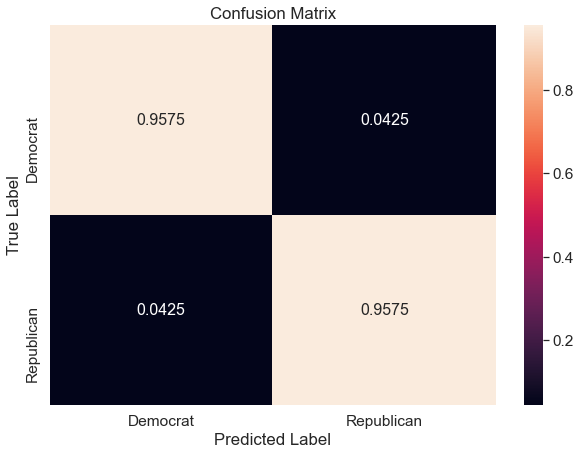

In [80]:
cf_matrix = confusion_matrix(y_validate_ntpart, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The predictive accuracy drastically increases with the addition of non-text features.

### Position predictions

In [81]:
# for position
X_train_ntpos, X_test_ntpos, y_train_ntpos, y_test_ntpos = train_test_split(combined_x, y_pos, train_size = .80, test_size=0.20,
                                                   stratify=y_pos)

X_train_ntpos, X_validate_ntpos, y_train_ntpos, y_validate_ntpos = train_test_split(X_train_ntpos, y_train_ntpos, train_size = .75, test_size = .25, 
                                                           stratify = y_train_ntpos)

In [82]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_ntpos, y_train_ntpos.ravel())

In [83]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train_ntpos, y_train_ntpos)

best_logit_pred = logit_grid.best_estimator_.predict(X_validate_ntpos)

print(logit_grid.best_params_)
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate_ntpos))

{'C': 0.8, 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'liblinear'}
Validation Accuracy 0.99375


In [84]:
logit_grid.best_estimator_.fit(X_train_ntpos, y_train_ntpos.ravel())
y_pred = logit_model.predict(X_validate_ntpos)

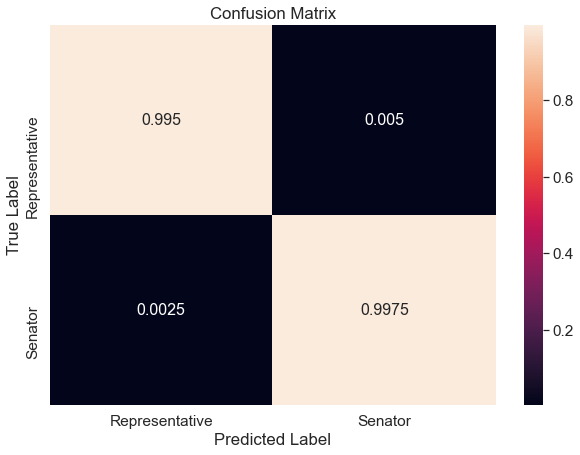

In [85]:
cf_matrix = confusion_matrix(y_validate_ntpos, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**KQ**: really excellent job, Annie! Your models crushed it because you went above and beyond with the hyperparameter tuning and sorting out the class imbalance. This is by far the best example of classification i've seen yet. Very well done!!

The predictive accuracy for both models is extremely high. This is probably because both models were trained on balanced data (equal number of tweets for Democrat Representative, Democrat Senator, Republican Representative, Republican Senator), robust data (4,000 tweets), and used a combination of text and non-text data. The text portion of the data included token frequency inverse document frequency featurization. In EDA, word choice seemed highly distinguishable, making tf-idf a highly effective featurization method. The non-text data incorporated gender, state, and the proportions of Democrat and Republican votes from the state in 2012 and 2016, which obviously added a great deal of distinguishing information to the models. Interestingly, the predictive accuracy is now higher for position than for party.

## Discussion Questions

1- Why do standard preprocessing techniques need to be further customized to a particular corpus?

It is important to pay attention to features of the corpus during preprocessing, because particular corpora may have unique features that are important to highlight or regulate. For example, twitter data has a lot of superfluous information that is better to remove, for instance `RT`, `QT` `@`. However, for certain applications, you may want to keep punctuation such as quotes, to show quoted material in the tweet. 

2- Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

During exploratory data analysis, sentiment analysis did not seem to be a good metric of differences between Senators and Representatives. However, Republicans seemed to have a slight positive skew on polarity, whereas Democrats seemed to have a slight negative skew. These observations may be reinforced in the fact that the logistic regression model with engineered features (which included sentiment scores) gave better predictive accuracy when distinguishing across parties than across positions. However, the engineered features data also included word count, which seemed to be a better predictor for party (longer tweets from Democrats) than for position, so it is unclear whether the predictive accuracy of the model is more due to word count or sentiment.

3- Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

It is far easier to see a pattern from data than to show that a pattern within a subset of data is also present in a separate subset of data. In other words, using labeled data with a supervised learning algorithm (especially with test and training sets) is a way to reduce overfitting of patterns to data. Differences that may appear large in visualization methods may not actually bear out statistically.

4- Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The combination of text and non-text features yielded the highest predictive accuracy scores. In a way, non-text features provide the context for text features, thereby giving the fullest picture of the data. For this data set in particular, the non-text features were extremely helpful as they provided relative percentage of Democrat and Republican voters in 2012 and 2016 for the legislators' states. This information provide to be extremely helpful in predicting the party of the legislator, as the legislator will most likely belong to the party that is most representative of their constituents. However, this information does not seem like it would be particularly useful when predicting what position the legislator holds in Congress. Gender also does not seem like it would be a good predictor, as roughly 25% of both the Senate and the House is female. 

**KQ**: awesome job Annie! 